# Sizing Scripts for OTA

In [ ]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from pygmid import Lookup as lk
import pandas as pd

### 1. Sizing FVF Cell
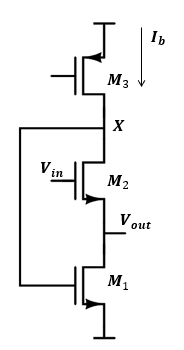

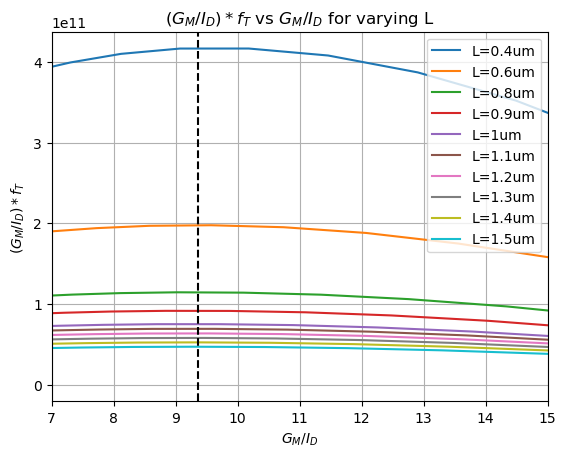

In [3]:
nch = lk('../gmid_luts/nfet_01v8.mat')

vgs = nch['VGS']
l_vec = [0.4, 0.6, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
leg = []
gm_id_opt = []
for l in l_vec:
    gm_id = nch.look_up('GM_ID', L = l, VDS = 0.9, VSB = 0)
    ft = nch.look_up('GM_CGG', L = l, VDS = 0.9, VSB = 0)
    gm_id_ft = np.multiply(gm_id, ft)
    plt.plot(gm_id, gm_id_ft)
    max_id = gm_id_ft.argmax()
    gm_id_opt.append(gm_id[max_id])
    leg.append('L='+str(l)+'um')
    plt.grid(True)
plt.legend(leg)
plt.ylabel('($G_M/I_D)*f_T$')
plt.xlabel('$G_M/I_D$')
plt.xlim(7, 15)
plt.title('($G_M/I_D)*f_T$ vs $G_M/I_D$ for varying L')
gm_id_ballpark = np.average(gm_id_opt)
plt.axvline(x = gm_id_ballpark, color = 'k', linestyle = '--')
plt.show()

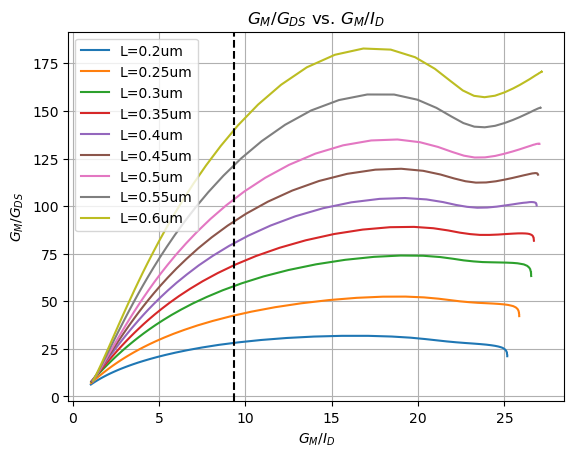

In [4]:
l_vec = [i/100 for i in range(20, 65, 5)]
leg = []
for l in l_vec:
    gm_id = nch.look_up('GM_ID', L = l, VDS = 0.9, VSB = 0)
    gm_gds = nch.look_up('GM_GDS', L = l, VDS = 0.9, VSB = 0)
    plt.plot(gm_id, gm_gds)
    leg.append('L='+str(l)+'um')
    plt.grid(True)
plt.legend(leg)
plt.title('$G_M/G_{DS}$ vs. $G_M/I_D$')
plt.xlabel('$G_M/I_D$')
plt.ylabel('$G_M/G_{DS}$')
#plt.ylim(60, 80)
plt.axvline(x = gm_id_ballpark, color = 'k', linestyle = '--')
plt.show()

In [5]:
Ib = 10e-6 # In Amperes
Vdd = 1.8 # In Volts
gm_id2 = gm_id_ballpark # V^-1 (Ballpark for maximum gmid*ft)
gm2 = Ib*gm_id2 # In S
L2 = 0.5 # In um
gm_gds2 = nch.look_up('GM_GDS', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2) # V/V
print(f'(gm2/gds2) = {gm_gds2}')
gds2 = gm2/gm_gds2
id_w2 = nch.look_up('ID_W', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2) 
W2 = Ib/id_w2
Vgs2 = nch.look_upVGS(GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Vt2 = nch.look_up('VT', VGS=Vgs2 , VDS = 0.9, VSB = 0, L = L2)
Vov2 = Vgs2 - Vt2
print(f'(Vgs2) = {Vgs2}')

(gm2/gds2) = 103.76105870622168
(Vgs2) = 0.8133680888271879


In [6]:

Css2 = gm2/nch.look_up('GM_CSS', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2) 
Cdd2 = gm2/nch.look_up('GM_CDD', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Cgs2 = gm2/nch.look_up('GM_CGS', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Cgd2 = gm2/nch.look_up('GM_CGD', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Ao = gm_gds2

# approximating Cout & Cx (maybe iterated later for accuracy)
Cout = 2*Css2 + Cdd2
Cx = 2*Cdd2 + Cgs2 + Ao*Cgd2

In [7]:
PM = np.array(70) # deg
gm1 = 1.00*np.tan((90-PM)*np.pi/180)*(Cx/Cout)*gm2/2 #value 0.26 is got from multiple iterations
gm_id1 = gm1/Ib
L1 = 1.5
id_w1 = nch.look_up('ID_W', GM_ID = gm_id1, VDS = 0.25, VSB = 0, L = L1) 
W1 = Ib/id_w1
gm_gds1 = nch.look_up('GM_GDS', GM_ID = gm_id1, VDS = 0.25, VSB = 0, L = L1)
gds1 = gm1/gm_gds1
Vgs1 = nch.look_upVGS(GM_ID = gm_id1, VDS = 0.25, VSB = 0, L = L1)
Vt1 = nch.look_up('VT', VGS=Vgs1 , VDS = 0.25, VSB = 0, L = L1)
Vov1 = Vgs1 - Vt1
print(f'(Vov1) = {Vov1}')

(Vov1) = 0.2028420952540697


In [8]:
Vdsat3 = min(Vdd-Vov1-Vt1-0.150, Vdd-0.9-0.25-0.150)
print(f'(Vdsat3) = {Vdsat3}')
gm_id3 = 2/Vdsat3
pch_lvt = lk('../gmid_luts/pfet_01v8_lvt.mat')
gm3 = gm_id3*Ib
L3 = 3
gm_gds3 = pch_lvt.look_up('GM_GDS', GM_ID = gm_id3, VDS = Vdd-0.9-0.25, VSB = 0, L = L3)
gds3 = gm3/gm_gds3
id_w3 = pch_lvt.look_up('ID_W', GM_ID = gm_id3, VDS = Vdd-0.9-0.25, VSB = 0, L = L3)
W3 = Ib/id_w3
Vgs3 = pch_lvt.look_upVGS(GM_ID = gm_id3, VDS = Vdd-0.9-0.25, VSB = 0, L = L3)
Vt3 = pch_lvt.look_up('VT', VGS=Vgs3 , VDS = Vdd-0.9-0.25, VSB = 0, L = L3)
Vov3 = Vgs3 - Vt3

(Vdsat3) = 0.5


In [9]:
Gm = (gm2/gds2)*(1+gm1/gds3)/(1/gds2 + 1/gds3)
Gout = (1+gm1/gds3)*(1 + (gm2)/gds2)/(1/gds2 + 1/gds3) + gds1
Ao = Gm/Gout

k = 1.38e-23
T = 300
kT = k*T
y1 = nch.look_up('STH', VGS=Vgs1 , VDS = 0.25, VSB = 0, L = L1)/(4*kT*gm1) 
y2 = nch.look_up('STH', VGS=Vgs2 , VDS = 0.9, VSB = 0, L = L2)/(4*kT*gm2)  
y3 = pch_lvt.look_up('STH', VGS=Vgs3 , VDS = Vdd-0.9-0.25, VSB = 0, L = L3)/(4*kT*gm3) 
TN_out_psd = 4*kT*(y3*gm3/(gm2**2) + y1/(gm1* (gm2/gds2)**2) + y2/gm2) # V^2/f
print(f'(TN_out_psd) = {TN_out_psd}')

(TN_out_psd) = 1.866617374760317e-15


In [10]:
size_data = {
    'Type': ['nfet_1v8', 'nfet_1v8', 'pfet_1v8_lvt'],
    'W': [W1, W2, W3],
    'L': [L1, L2, L3],
    'GM_ID': [gm_id1, gm_id2, gm_id3],
    'GM_GDS': [gm_gds1, gm_gds2, gm_gds3],
    'ID_W': [id_w1, id_w2, id_w3]
}
size_df = pd.DataFrame(size_data, index = ['M1', 'M2', 'M3'])
size_df

,Type,W,L,GM_ID,GM_GDS,ID_W
M1,nfet_1v8,2.775135,1.5,9.253243,23.765647406954272,3.6034282414684994e-06
M2,nfet_1v8,0.976487,0.5,9.358845,103.76105870622168,1.024078846344254e-05
M3,pfet_1v8_lvt,3.755822,3.0,4.000000,52.34144278242294,2.6625329065143943e-06


In [11]:
Css2 = gm2/nch.look_up('GM_CSS', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2) 
Cdd2 = gm2/nch.look_up('GM_CDD', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Cgs2 = gm2/nch.look_up('GM_CGS', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Cgd2 = gm2/nch.look_up('GM_CGD', GM_ID = gm_id2, VDS = 0.9, VSB = 0, L = L2)
Css1 = gm1/nch.look_up('GM_CSS', GM_ID = gm_id1, VDS = 0.5, VSB = 0, L = L1) 
Cdd1 = gm1/nch.look_up('GM_CDD', GM_ID = gm_id1, VDS = 0.5, VSB = 0, L = L1)
Cgs1 = gm1/nch.look_up('GM_CGS', GM_ID = gm_id1, VDS = 0.5, VSB = 0, L = L1)
Cgd1 = gm1/nch.look_up('GM_CGD', GM_ID = gm_id1, VDS = 0.5, VSB = 0, L = L1)
Css3 = gm3/pch_lvt.look_up('GM_CSS', GM_ID = gm_id3, VDS = 0.4, VSB = 0, L = L3) 
Cdd3 = gm3/pch_lvt.look_up('GM_CDD', GM_ID = gm_id3, VDS = 0.4, VSB = 0, L = L3)
Cgs3 = gm3/pch_lvt.look_up('GM_CGS', GM_ID = gm_id3, VDS = 0.4, VSB = 0, L = L3)
Cgd3 = gm3/pch_lvt.look_up('GM_CGD', GM_ID = gm_id3, VDS = 0.4, VSB = 0, L = L3)

# approximating Cout & Cx (maybe iterated later for accuracy)
Cout_new = 2*Css2 + Cdd1
Cx_new = Cdd2 + Cdd3 + Cgs1 + (gm1/gds1)*Cgd1

In [12]:
PM = np.array([70]) # deg
gm1_new = np.tan((90-PM)*np.pi/180)*(Cx_new/Cout_new)*gm2/2
print(gm1_new/gm1)

[1.03823492]


In [13]:
# ACL
ACL = 1/(1 + (gds2/gm2))
fz = gm1/(Cgd1*2*np.pi)
# UGF
Rx = 1/gds3
print(f'(Rx) = {Rx/1e3}')
fpx = 1/(Rx*Cx_new*np.pi*2)
UGF = gm1/(Cx_new*2*np.pi)
# PM
Rout = (1 + (gds2/gds3))/gm2
fpout = 1/(Rout*Cout_new*np.pi*2)
PM_new = 90 - np.arctan(UGF/fpout)*180/np.pi
df = pd.DataFrame( [ACL, UGF/1e6, fz/1e6, fpx/1e6, fpout/1e6, PM_new], \
                   ['ACL', 'UGF (MHz)', 'Fz (MHz)', 'Fpx (MHz)', 'Fpout (MHz)', 'PM (deg)'], columns=['Value']); df.round(2)

(Rx) = 1308.5360695605734


,Value
ACL,0.99
UGF (MHz),395.29
Fz (MHz),21014.92
Fpx (MHz),3.26
Fpout (MHz),1034.35
PM (deg),69.09


In [14]:
#voltage headroom fo FVF cells
Vin_max = Vov1 + Vt1 + Vt2
Vin_min = Vov1 + Vov2 + Vt2
print(f'(Vin_max) = {Vin_max}')
print(f'(Vin_min) = {Vin_min}')

Vdd_min = Vov3 + Vov1 + Vt1
print(f'(Vdd_min) = {Vdd_min}')

(Vin_max) = 1.4005420952540697
(Vin_min) = 1.0162101840812576
(Vdd_min) = 1.3581905624817585


## 2. Sizing OTA Transistors
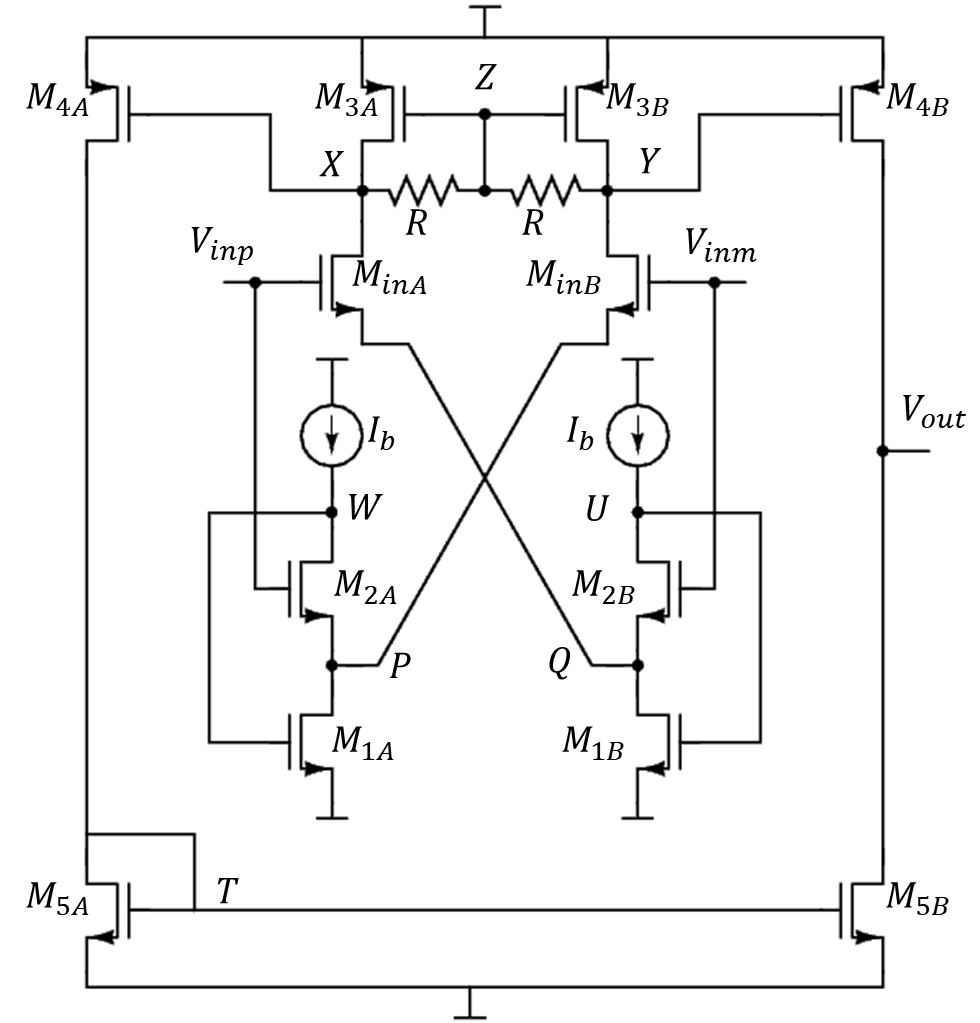

In [15]:
Vgs_in = Vgs2
Vds_in = 0.9
Vds1 = 0.25

#finding parameters of differential pair loads(M_3AB)
Vds_3AB = 1.8 - Vds_in - Vds1
Vgs_3AB = Vds_3AB
L3AB = 1
gm_id_3AB = pch_lvt.look_up('GM_ID', L = L3AB, VGS = Vgs_3AB, VDS = Vds_3AB, VSB = 0)
gm_gds_3AB = pch_lvt.look_up('GM_GDS', L = L3AB, VGS = Vgs_3AB, VDS = Vds_3AB, VSB = 0)
gm_3AB = gm_id_3AB*Ib
gds_3AB = gm_3AB/gm_gds_3AB
print(f'(gm_id_3AB) = {gm_id_3AB}')
print(f'(gm_gds_3AB) = {gm_gds_3AB}')
id_w_3AB = pch_lvt.look_up('ID_W', GM_ID = gm_id_3AB, VDS = Vds_3AB, VSB = 0, L = L3AB)
W_3AB = Ib/id_w_3AB
print(f'(W_3AB) = {W_3AB}')

(gm_id_3AB) = 8.741841914430747
(gm_gds_3AB) = 56.72941176470589
(W_3AB) = 9.064539521392314


In [16]:
gds_in = gds2
Cdd_in = Cdd2
gm_in = gm2
Cdd_3AB = gm_3AB/pch_lvt.look_up('GM_CDD', GM_ID = gm_id_3AB, VDS = Vds_3AB, VSB = 0, L = L3AB)
Cgs_3AB = gm_3AB/pch_lvt.look_up('GM_CGS', GM_ID = gm_id_3AB, VDS = Vds_3AB, VSB = 0, L = L3AB)
Cgd_3AB = gm_3AB/pch_lvt.look_up('GM_CGD', GM_ID = gm_id_3AB, VDS = Vds_3AB, VSB = 0, L = L3AB)
print(f'(Cdd_in) = {Cdd_in}')
print(f'(Cdd_3AB) = {Cdd_3AB}')
print(f'(Cgs_3AB) = {Cgs_3AB}')
print(f'(Cgd_3AB) = {Cgd_3AB}')


(Cdd_in) = 6.811181890544374e-16
(Cdd_3AB) = 4.102180928208847e-15
(Cgs_3AB) = 3.393763596809282e-14
(Cgd_3AB) = 1.9012690355329947e-16


In [17]:
#finding parameters for output stage pmos mirrors for mirroring ratio=1
L4 = L3AB
k = 1
W4 = k*W_3AB
gm_id4 = gm_id_3AB
print(f'(gm_id4) = {gm_id4}')
gm4 = gm_3AB
gm_gds4 = gm_gds_3AB
gds4 = gds_3AB
id_w4 = pch_lvt.look_up('ID_W', GM_ID = gm_id4, VDS = Vds_3AB, VSB = 0, L = L4)
Cdd4 = gm4/pch_lvt.look_up('GM_CDD', GM_ID = gm_id4, VDS = Vds_3AB, VSB = 0, L = L4)
Cgs4 = gm4/pch_lvt.look_up('GM_CGS', GM_ID = gm_id4, VDS = Vds_3AB, VSB = 0, L = L4)
Cgd4 = gm4/pch_lvt.look_up('GM_CGD', GM_ID = gm_id4, VDS = Vds_3AB, VSB = 0, L = L4)
Cxy = Cgs4 + (gm4*Cgd4/gds4) + Cdd_in
print(f'(Cxy) = {Cxy}')
print(f'(Cdd4) = {Cdd4}')

(gm_id4) = 8.741841914430747
(Cxy) = 4.54045415563709e-14
(Cdd4) = 4.102180928208847e-15


In [18]:
#creating a loop to find at which value of LCMFB resistors and at which W/L of the output stage nmos mirror design goals are met

l_vec = [i/100 for i in range (15, 400, 15)]
r_vec = [i*1e3 for i in range(35, 45, 1)]
leg = []
gain_opt = []
for l in l_vec:
   for r in r_vec: 
        L5 = l
        Vds4 = Vds_3AB
        Vds5 = 1.8 - Vds4
        Vgs5 = Vds5
        gm_id5 = nch.look_up('GM_ID', L = L5, VGS = Vgs5, VDS = Vds5, VSB = 0)
        gm_gds5 = nch.look_up('GM_GDS', L = L5, VGS = Vgs5, VDS = Vds5, VSB = 0)
        gm5 = gm_id5*Ib
        gds5 = gm5/gm_gds5
        id_w5 = nch.look_up('ID_W', GM_ID = gm_id5, VDS = Vds5, VSB = 0, L = L5)
        W5 = Ib/id_w5
        Cdd5 = gm5/nch.look_up('GM_CDD', GM_ID = gm_id5, VDS = Vds5, VSB = 0, L = L5)
        Cout = Cdd5 + Cdd4 + 80e-12
        Rout = 1/(gds4 + gds5)
        Rxy = 1/(gds_3AB + gds_in + (1/(r)))
        gain = 20*np.log10(2*gm_in*Rxy*gm4*Rout)
        g = 2*gm_in*Rxy*gm4*Rout
        GBW = 2*gm_in*Rxy*gm4/(Cout*2*np.pi)
        fpxy = 1/(Rxy*Cxy*2*np.pi)
        PM = 90 - np.arctan(GBW/fpxy)*180/np.pi
        if PM >= 70 and gain >= 40 and W5 >= 0.9 and GBW >= 700e3: #design goals
            print(f'l5 = {L5}')
            print(f'W5 = {W5}')
            print(f'R (kohm) = {r/1e3}')
            print(f'DCgain (dB) = {gain}')
            print(f'gain (V/V) = {g}')
            print(f'GBW (kHz) = {GBW/1e3}')
            print(f'fpxy (kHz) = {fpxy/1e3}')
            print(f'PM (deg) = {PM}')
            
 

l5 = 3.45
W5 = 0.9131169246221982
R (kohm) = 35.0
DCgain (dB) = 49.57649654655292
gain (V/V) = 301.17909733161326
GBW (kHz) = 1049.5347515274716
fpxy (kHz) = 108713.55106420063
PM (deg) = 89.44687628151351
l5 = 3.45
W5 = 0.9131169246221982
R (kohm) = 36.0
DCgain (dB) = 49.80165996937931
gain (V/V) = 309.0886078517199
GBW (kHz) = 1077.0974417406103
fpxy (kHz) = 105931.59484201284
PM (deg) = 89.41744471028287
l5 = 3.45
W5 = 0.9131169246221982
R (kohm) = 37.0
DCgain (dB) = 50.02016252482179
gain (V/V) = 316.9626770521251
GBW (kHz) = 1104.5366277099415
fpxy (kHz) = 103300.01463183522
PM (deg) = 89.38738754608988
l5 = 3.45
W5 = 0.9131169246221982
R (kohm) = 38.0
DCgain (dB) = 50.23236166420933
gain (V/V) = 324.80154261111386
GBW (kHz) = 1131.8531376855724
fpxy (kHz) = 100806.93864324591
PM (deg) = 89.356714093844
l5 = 3.45
W5 = 0.9131169246221982
R (kohm) = 39.0
DCgain (dB) = 50.438586965031085
gain (V/V) = 332.6054400864726
GBW (kHz) = 1159.047792528197
fpxy (kHz) = 98441.71270535344
PM (d

In [19]:
#taking best values for previous iterations
L5 = 3.45
W5 = 0.9
Vds4 = Vds_3AB
Vds5 = 1.8 - Vds4
Vgs5 = Vds5
gm_id5 = nch.look_up('GM_ID', L = L5, VGS = Vgs5, VDS = Vds5, VSB = 0)
gm_gds5 = nch.look_up('GM_GDS', L = L5, VGS = Vgs5, VDS = Vds5, VSB = 0)
gm5 = gm_id5*Ib
gds5 = gm5/gm_gds5
id_w5 = nch.look_up('ID_W', GM_ID = gm_id5, VDS = Vds5, VSB = 0, L = L5)
R = 40.0
DCgain = 50.63914295452027
GBW = 1186.121405791315
PM = 89.29355491810513
size_data = {
    'Type': ['nfet_1v8', 'nfet_1v8', 'pfet_1v8_lvt', 'pfet_1v8_lvt', 'pfet_1v8_lvt', 'nfet_1v8'],
    'W': [W1, W2, W3, W_3AB, W4, W5],
    'L': [L1, L2, L3, L3AB, L4, L5],
    'GM_ID': [gm_id1, gm_id2, gm_id3, gm_id_3AB, gm_id4, gm_id5],
    'GM_GDS': [gm_gds1, gm_gds2, gm_gds3, gm_gds_3AB, gm_gds4, gm_gds5],
    'ID_W': [id_w1, id_w2, id_w3, id_w_3AB, id_w4, id_w5]
}
size_df = pd.DataFrame(size_data, index = ['M1', 'M2', 'M3', 'M_3AB', 'M4', 'M5'])
size_df

,Type,W,L,GM_ID,GM_GDS,ID_W
M1,nfet_1v8,2.775135,1.50,9.253243,23.765647406954272,3.6034282414684994e-06
M2,nfet_1v8,0.976487,0.50,9.358845,103.76105870622168,1.024078846344254e-05
M3,pfet_1v8_lvt,3.755822,3.00,4.0,52.34144278242294,2.6625329065143943e-06
M_3AB,pfet_1v8_lvt,9.064540,1.00,8.741841914430747,56.72941176470589,1.1032e-06
M4,pfet_1v8_lvt,9.064540,1.00,8.741841914430747,56.72941176470589,1.1032e-06
M5,nfet_1v8,0.900000,3.45,3.045376608852683,144.49512338592982,1.0951499999999997e-05


In [20]:
df = pd.DataFrame( [DCgain, GBW, PM, R], \
                   ['DCgain (dB)', 'GBW (kHz)', 'PM (deg)', 'R (kOhm)'], columns=['Value']); df.round(2)

,Value
DCgain (dB),50.64
GBW (kHz),1186.12
PM (deg),89.29
R (kOhm),40.00


**Note: The sizes are slightly modified for the Offset/Noise(flicker)/Slew (Refer to schematic in `sim_sch/xschem/ota.sch`)**